In [1]:
using Pkg; Pkg.activate("../");
using LatticeLab
Pkg.activate("../../cifio");
using cifio

In [13]:
function cellp2a(cellp; digits=12)
    @inline rd(x)  = round(x,digits=digits)
    @inline d2r(x) = Float64(x*π/180)
    (a_Ang, b_Ang, c_Ang, alpha, beta, gamma) = cellp[1:6]
    alphar, betar, gammar = d2r.([alpha, beta, gamma])
    cell_px = a_Ang.*[1.0, 0.0, 0.0 ]
    cell_py = b_Ang.*[cos(gammar), sin(gammar), 0.0 ]
    cell_pz = c_Ang.*[
                 cos(betar),  
                (cos(alphar)-cos(betar)*cos(gammar))/sin(gammar),
                 sqrt(1.0 - cos(alphar)^2 - cos(betar)^2 - cos(gammar)^2 
                    + 2*cos(alphar)*cos(betar)*cos(gammar))/sin(gammar)
    ]
    return hcat(cell_px, cell_py, cell_pz) .|> rd
end


function CIF2UC(
    cif::CIF, 
    orbs::Vector{Vector{Symbol}}
    )
    na = length(cif.frac)
    mm  = [Symbol("$c$i") for (i,c) in enumerate(first.(cif.frac))]
    aa  = LatticeLab.Coordinates(cellp2a(cif.cellp))
    ff  = hcat([f[2:4] for f ∈ cif.frac]...)
    dd  = aa * ff |> LatticeLab.Coordinates  # Cartesian
    xx  = LatticeLab.Orbits.(orbs)
    UC = LatticeLab.UnitCell(3, na, aa, dd, mm, xx)
    return UC
end

CIF2UC (generic function with 1 method)

In [14]:
Mo2N_CIF = split("""
Mo2N
_cell_length_a                           2.78373390
_cell_length_b                           2.78373390
_cell_length_c                          12.81473854
_cell_angle_alpha                       90.00000000
_cell_angle_beta                        90.00000000
_cell_angle_gamma                      120.00000000
_symmetry_Int_Tables_number            1
loop_
_space_group_symop_operation_xyz
   'x, y, z'

loop_
_atom_site_label
_atom_site_occupancy
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_type_symbol
Mo1  1.0     0.66666667     0.33333333    0.60982427  Mo
Mo2  1.0     0.33333333     0.66666667    0.39017573  Mo
N1  1.0     0.00000000     0.00000000    0.50000000  N
""", "\n", keepempty=false) .|> string |> CIF ;

In [15]:
UC_Mo2N = CIF2UC(
    Mo2N_CIF,
    [[:d14,:d24,:d34,:d44,:d54,:s5],
     [:d14,:d24,:d34,:d44,:d54,:s5],
     [:px2,:py2,:pz2]]
)

UnitCell(3, 3, [2.7837339 -1.39186695 0.0; 0.0 2.410784274776 0.0; 0.0 0.0 12.81473854], [1.3918669639186696 -1.3918669550250229e-8 0.0; 0.8035947502227191 1.607189524553281 0.0; 7.814738575396365 4.999999964603634 6.40736927], Union{Number, Symbol}[:Mo1, :Mo2, :N3], [[:d14, :d24, :d34, :d44, :d54, :s5], [:d14, :d24, :d34, :d44, :d54, :s5], [:px2, :py2, :pz2]])

In [33]:
BBOX(m,n) = ([-0.021,-0.01,-1e-6], # origin
             [1 0 0; 0 1 0; 0 0 1],    # supercell basis
             [m,n,1],                  # supercell shifts
             [true,true,false])        # P.B.C. conditions

LN_Mo2N = LatticeLab.link_info_sublattice_pairs_by_nth(
    Dict((1,3)=>(:f1,1),(2,3)=>(:f2,1),(1,2)=>(:g,1)),
    UC_Mo2N;
    bounding_box = BBOX(1,1),
    rounding_digits = 10
) ;

In [37]:
Mo2N = build_lattice(LN_Mo2N,BBOX(2,2)) ;

┌ Info: build_lattice() : 
│ 		 margin = 1
└ @ LatticeLab /home/dabajabaza/jianguoyun/Nutstore/LatticeLab/src/lattice/build_lattice.jl:256
┌ Info: generate_R0_compute_EqV() : 
│ 		 bbox = ([-0.021, -0.01, -1.0e-6], [1 0 0; 0 1 0; 0 0 1], [2, 2, 1], Bool[1, 1, 0])
│ 		 N_min, N_max = ([-2, -2, 0], [4, 4, 0])
└ @ LatticeLab /home/dabajabaza/jianguoyun/Nutstore/LatticeLab/src/lattice/build_lattice.jl:39
┌ Info: generate_R0_compute_EqV() : compute EqV ...
└ @ LatticeLab /home/dabajabaza/jianguoyun/Nutstore/LatticeLab/src/lattice/build_lattice.jl:53


  0.003672 seconds (53.27 k allocations: 3.677 MiB)
  0.000393 seconds (6.62 k allocations: 393.203 KiB)


┌ Info: generate_f() : main loop ...
└ @ LatticeLab /home/dabajabaza/jianguoyun/Nutstore/LatticeLab/src/lattice/build_lattice.jl:180


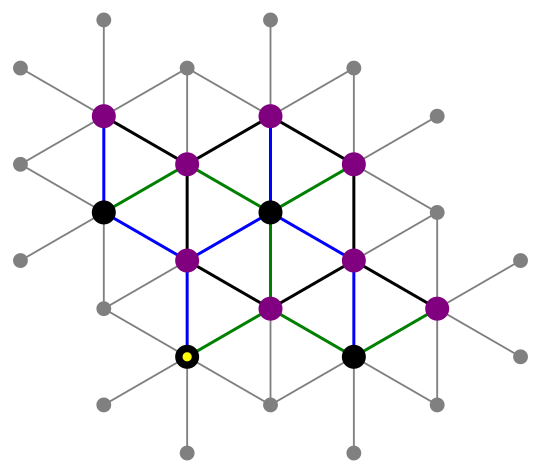

In [38]:
VSTYLE = Dict(
    :Mo1=>("purple",12.0,:dot),
    :Mo2=>("purple",12.0,:dot),
    :N3 =>("black", 12.0,:dot)
)
ESTYLE = Dict(
    :f1=>("green", 3.0,:solid),
    :f2=>("blue",  3.0,:solid),
    :g=> ("black", 3.0,:solid)
)
display("image/svg+xml", 
    show_lattice_svg(Mo2N, VSTYLE, ESTYLE; upscale=60))